# Imports

In [43]:
import time
import pynlo
import numpy as np
import matplotlib.pyplot as plt
from load_data import load_data
from generate_data import generate_data
from train_models import train_models, train_best
from IPython.display import clear_output

# Generate data
`generate_data()` runs `PyNLO` for each given parameter and saves the temporal/spectral inputs/output evolution in `DATA_DIR`

In [44]:
DATA_DIR = f"./testing_data/nlse_time-{int(time.time())}/"
LOG_DIR = "logs/"

generate_data(DATA_DIR)

100%|██████████| 32/32 [08:56<00:00, 16.77s/it]


Done generating data. The following files have been created:
x_pulse_AW.npy: (1024, 10, 1024)
x_pulse_AT.npy: (1024, 10, 1024)
y_AW.npy: (1024, 110, 1024)
y_AT.npy: (1024, 110, 1024)


# Train models
`keras.tuner.RandomSearch()` iterates randomly over hyperparameters and runs a model for each. `train_models()` runs a given amount of these models and returns the best one. `train_best()` immediately follows, training and returning the best performing model. 

In [45]:
# for testing
# DATA_DIR = "./testing_data/nlse_time-1657917589/"
# LOG_DIR = "logs/"

x_train, y_train, x_val, y_val, x_test, y_test = load_data(
    DATA_DIR=DATA_DIR, validation_split=0.2, test_split=0.2
)

Input data shape: (1024, 10, 1024)
Output data shape: (1024, 110, 1024)
Training data shape: (616, 10, 1024)
Validation data shape: (204, 10, 1024)
Testing data shape: (204, 10, 1024)


In [46]:
tuner, hps = train_models(
    DATA_DIR=DATA_DIR,
    LOG_DIR=LOG_DIR,
    x_train=x_train,
    y_train=y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
)

Trial 1 Complete [00h 01m 01s]
val_mse: 5.890618467674358e-06

Best val_mse So Far: 5.890618467674358e-06
Total elapsed time: 00h 01m 01s
INFO:tensorflow:Oracle triggered exit


Epoch 1/10
20/20 [==============================] - 5s 165ms/step - loss: 0.2497 - mse: 0.2497 - mae: 0.4997 - val_loss: 0.2496 - val_mse: 0.2496 - val_mae: 0.4996
Epoch 2/10
20/20 [==============================] - 3s 151ms/step - loss: 0.2494 - mse: 0.2494 - mae: 0.4993 - val_loss: 0.2492 - val_mse: 0.2492 - val_mae: 0.4992
Epoch 3/10
20/20 [==============================] - 3s 152ms/step - loss: 0.2489 - mse: 0.2489 - mae: 0.4989 - val_loss: 0.2487 - val_mse: 0.2487 - val_mae: 0.4987
Epoch 4/10
20/20 [==============================] - 3s 149ms/step - loss: 0.2483 - mse: 0.2483 - mae: 0.4982 - val_loss: 0.2477 - val_mse: 0.2477 - val_mae: 0.4977
Epoch 5/10
20/20 [==============================] - 3s 147ms/step - loss: 0.2451 - mse: 0.2451 - mae: 0.4951 - val_loss: 0.2384 - val_mse: 0.2384 - val_mae: 0.4882
Epoch 6/10
20/20 [==============================] - 3s 151ms/step - loss: 0.1808 - mse: 0.1808 - mae: 0.4171 - val_loss: 0.0537 - val_mse: 0.0537 - val_mae: 0.2244
Epoch 7/10
20/20

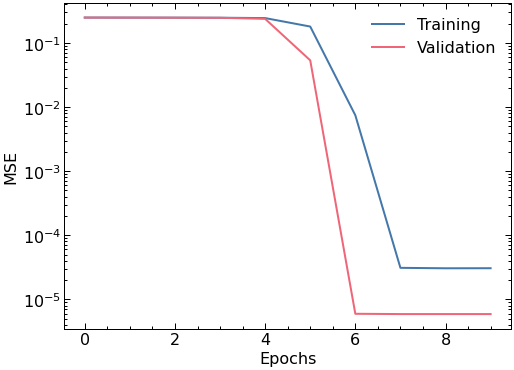

In [47]:
model = train_best(
    DATA_DIR=DATA_DIR,
    LOG_DIR=LOG_DIR,
    x_train=x_train,
    y_train=y_train,
    validation_data=(x_val, y_val),
    tuner=tuner,
    hps=hps,
    epochs=10,
)

# Make predictions and plot results
Makes a prediction with the best performing model on a data set that is outside the initial training data.

In [48]:
pred = np.absolute(model.predict(x_test))
pred = pred / np.max(pred)

7/7 [==============================] - 1s 26ms/step


# Plot results

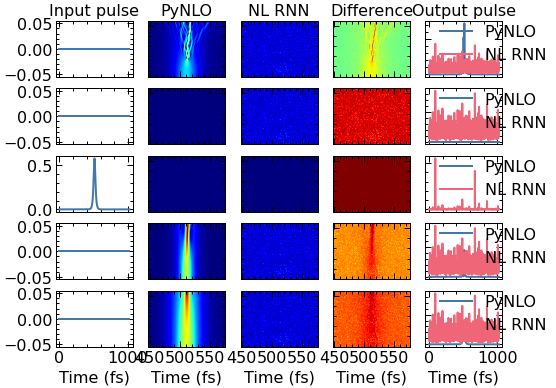

In [49]:
plt.style.use(["science", "notebook", "bright"])

num_examples = 5

_, axes = plt.subplots(num_examples, 5)  # , sharex=True)

xmin = 512 - 64
xmax = 512 + 64

for i in range(num_examples):
    x = pred[i, :, :]

    y = np.absolute(y_test[i, :, :])

    axes[i, 0].plot(np.absolute(np.transpose(x_test[i, 0, :])))
    axes[i, 0].set_xlabel("Time (fs)")

    axes[i, 1].imshow(y, aspect="auto", cmap="jet", origin="lower")
    axes[i, 1].set_xlim(xmin, xmax)
    axes[i, 1].set_xlabel("Time (fs)")

    axes[i, 2].imshow(x, aspect="auto", cmap="jet", origin="lower")
    axes[i, 2].set_xlim(xmin, xmax)
    axes[i, 2].set_xlabel("Time (fs)")

    axes[i, 3].imshow(y - x, aspect="auto", cmap="jet", origin="lower")
    axes[i, 3].set_xlim(xmin, xmax)
    axes[i, 3].set_xlabel("Time (fs)")

    axes[i, 4].plot(y[-1:, :][0], label="PyNLO")
    axes[i, 4].plot(x[-1:, :][0], label="NL RNN")
    axes[i, 4].set_xlabel("Time (fs)")
    axes[i, 4].legend()

    if i == 0:
        axes[i, 0].set_title("Input pulse")
        axes[i, 1].set_title("PyNLO")
        axes[i, 2].set_title("NL RNN")
        axes[i, 3].set_title("Difference")
        axes[i, 4].set_title("Output pulse")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for axis in axes.flat:
    axis.label_outer()

plt.show()

# Save publication quality plots

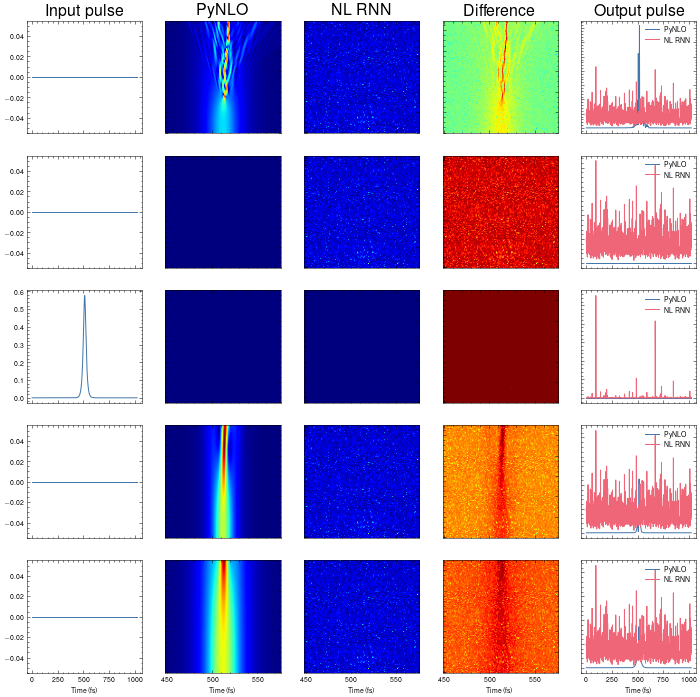

In [54]:
plt.style.use(["science", "nature", "bright"])

num_examples = 5

_, axes = plt.subplots(num_examples, 5, figsize=(12, 12))  # , sharex=True)

xmin = 512 - 64
xmax = 512 + 64

for i in range(num_examples):
    x = pred[i, :, :]

    y = np.absolute(y_test[i, :, :])

    axes[i, 0].plot(np.absolute(np.transpose(x_test[i, 0, :])))
    axes[i, 0].set_xlabel("Time (fs)")

    axes[i, 1].imshow(y, aspect="auto", cmap="jet", origin="lower")
    axes[i, 1].set_xlim(xmin, xmax)
    axes[i, 1].set_xlabel("Time (fs)")

    axes[i, 2].imshow(x, aspect="auto", cmap="jet", origin="lower")
    axes[i, 2].set_xlim(xmin, xmax)
    axes[i, 2].set_xlabel("Time (fs)")

    axes[i, 3].imshow(y - x, aspect="auto", cmap="jet", origin="lower")
    axes[i, 3].set_xlim(xmin, xmax)
    axes[i, 3].set_xlabel("Time (fs)")

    axes[i, 4].plot(y[-1:, :][0], label="PyNLO")
    axes[i, 4].plot(x[-1:, :][0], label="NL RNN")
    axes[i, 4].set_xlabel("Time (fs)")
    axes[i, 4].legend()

    if i == 0:
        axes[i, 0].set_title("Input pulse")
        axes[i, 1].set_title("PyNLO")
        axes[i, 2].set_title("NL RNN")
        axes[i, 3].set_title("Difference")
        axes[i, 4].set_title("Output pulse")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for axis in axes.flat:
    axis.label_outer()

plt.savefig(f"figures/results-{int(time.time())}.png", dpi=2400)

# Testing

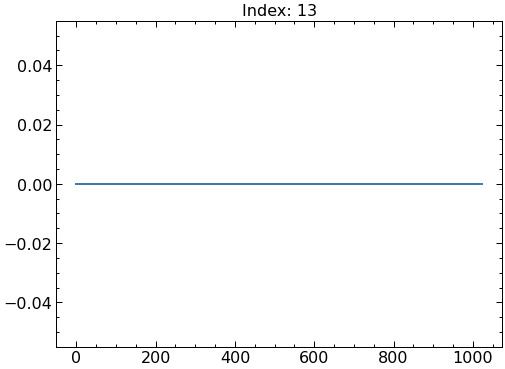

KeyboardInterrupt: 

In [51]:
plt.style.use(["science", "notebook", "bright"])

for i in range(1024):
    clear_output(wait=True)
    temp = np.absolute(x_test[i, 0, :])
    plt.plot(temp)
    plt.title(f"Index: {i}")
    plt.pause(0.1)

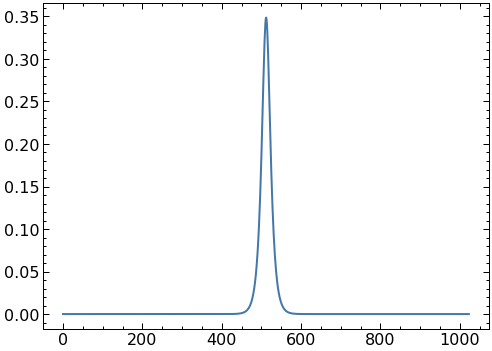

In [87]:
plt.plot(x_test[23, 0, :])

In [ ]:
plt.style.use(["science", "notebook", "bright"])

for i in range(1024):
    clear_output(wait=True)
    plt.imshow(np.absolute(y_test[i, :, :]), aspect="auto", cmap="jet")
    plt.title(f"Index: {i}")
    plt.pause(0.1)

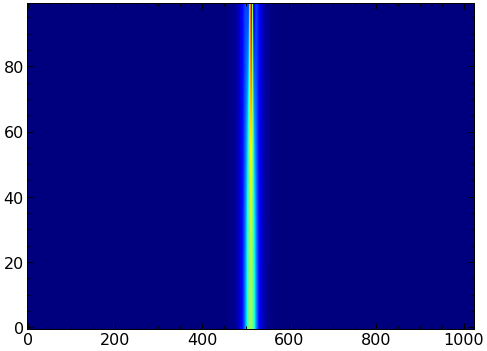

In [102]:
plt.imshow(np.absolute(y_test[73, 10:, :]), aspect="auto", cmap="jet", origin="lower")